In [46]:
import dill
import numpy as np
import sys
import os
np.set_printoptions(threshold=sys.maxsize)
CSV_PATH = "/home/zhimin90/CPT/CSVs/"

In [47]:
f_in = open(CSV_PATH + "density_matrix_t_series.pkl","rb")
matrix_test = dill.load(f_in)
f_in.close()
density_matrix_t_series = matrix_test


f_in = open(CSV_PATH + "grid_matrix.pkl","rb")
matrix_test = dill.load(f_in)
f_in.close()
grid_matrix = matrix_test

In [48]:
s = round(len(density_matrix_t_series)*.8)

In [49]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
#np.seterr(divide='ignore', invalid='ignore')
scaler = StandardScaler()
scaler2 = MinMaxScaler()
dm_series_np = np.array(density_matrix_t_series[:s])
flattened_matrix_np = np.reshape(dm_series_np, (dm_series_np.shape[0]*dm_series_np.shape[1], dm_series_np.shape[1]))

normalized_matrices = scaler.fit_transform(flattened_matrix_np)
normalized_matrices = scaler2.fit_transform(normalized_matrices)

inverseTcheck = scaler2.inverse_transform(normalized_matrices)
inverseTcheck = scaler.inverse_transform(inverseTcheck)

In [50]:
f = open(CSV_PATH +'Scalers.pkl', "wb")
dill.dump((scaler,scaler2), file=f)
f.close()

In [6]:
x_train = normalized_matrices[0:-normalized_matrices.shape[1]].copy()
y_train = normalized_matrices[normalized_matrices.shape[1]-1:-1].copy()
print(x_train.shape)
print(y_train.shape)

(311000, 1000)
(311000, 1000)


In [7]:
#x_train2 = np.reshape(x_train, (int(x_train.shape[0]/x_train.shape[1]), x_train.shape[1], x_train.shape[1]))
x_train2 = np.reshape(x_train, (int(x_train.shape[0]/x_train.shape[1]), x_train.shape[1], x_train.shape[1]))
x_train2 = np.reshape(x_train, (x_train2.shape[0] * x_train2.shape[1], 1, x_train2.shape[2]))
y_train2 = np.reshape(y_train, (int(y_train.shape[0]/y_train.shape[1]), y_train.shape[1], y_train.shape[1]))
y_train2 = np.reshape(y_train, (y_train2.shape[0]*y_train2.shape[1], y_train2.shape[2]))
print(x_train2.shape)
print(y_train2.shape)
x_train2.shape[2]

(311000, 1, 1000)
(311000, 1000)


1000

In [8]:
dm_series_np = np.array(density_matrix_t_series[s:])
flattened_matrix_np = np.reshape(dm_series_np, (dm_series_np.shape[0]*dm_series_np.shape[1], dm_series_np.shape[2]))

normalized_matrices_test = scaler2.transform(scaler.transform(flattened_matrix_np))
x_test = normalized_matrices_test[0:-normalized_matrices_test.shape[1]].copy()
y_test = normalized_matrices_test[normalized_matrices_test.shape[1]-1:-1].copy()

x_test2 = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
y_test2 = y_test 

In [9]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow.keras as keras
import types
import tempfile
import os


def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', mode='w', delete=True, dir=os.getcwd()) as fd:
            keras.models.save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = { 'model_str': model_str }
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5',mode='r', delete=True, dir=os.getcwd()) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = keras.models.load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = keras.models.Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__

tf.keras.backend.clear_session()
make_keras_picklable()

In [17]:
model = Sequential()
model.add(LSTM(1024, input_shape= (1, x_train2.shape[2]), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(1024, activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(1024, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(512, activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(x_train2.shape[2], activation='selu'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 1024)           8294400   
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1024)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 1024)           8392704   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1024)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1024)              8392704   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)              

In [18]:
opt = tf.keras.optimizers.Adamax(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
#opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
#opt = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
#opt = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)

model.compile(
    loss='mean_absolute_error',
    optimizer=opt,
    metrics=['accuracy'],
)

model.fit(x_train2,
          y_train2,
          epochs=1)

Train on 311000 samples
311000/311000 [==============================] - 820s 3ms/sample - loss: 0.0047 - accuracy: 0.9606


In [13]:
# Export the model to a SavedModel
#model.save(CSV_PATH + 'TensorFlowModel_train_save', save_format='tf')

In [10]:
#new_model = keras.models.load_model(CSV_PATH + 'TensorFlowModel_save')
model = keras.models.load_model(CSV_PATH + 'TensorFlowModel_train_save')

In [11]:
x_test.shape

(77000, 1000)

In [12]:
pred_test = model.predict(x_test2)

In [13]:
error_test = y_test2 - pred_test

In [14]:
np.mean(error_test[1,:1]/y_test2[1,:1])

0.00898979620873963

In [15]:
MAPE = np.mean(abs(error_test/y_test2))

In [16]:
MAPE

583066548501.1355

In [17]:
error_test.shape

(77000, 1000)

In [18]:
pred = pred_test 
pred.shape

(77000, 1000)

In [19]:
data = scaler.inverse_transform(scaler2.inverse_transform(pred))
print(type(data))
data2 = data.reshape((int(data.shape[0]/data.shape[1]), data.shape[1], data.shape[1]))
print(data2[-1].shape)

<class 'numpy.ndarray'>
(1000, 1000)


In [20]:
data2.shape

(77, 1000, 1000)

In [21]:
dm_series_np.shape

(78, 1000, 1000)

In [22]:
target_y_test = dm_series_np[1:,:,:]

In [23]:
print(np.max(target_y_test))
print(np.min(target_y_test))

1292.3568420468139
-1.8660912904154624e-13


In [24]:
MAE = np.mean(abs(target_y_test-data2))
MAE

4.743600439163767

In [25]:
MAPE = np.mean(abs((target_y_test-data2)/target_y_test))
MAPE

1108172484172289.2

#### MAPE run into issues with dividing by close to 0 probability density

In [26]:
RMSE = np.sqrt(np.mean(np.square(target_y_test-data2)))
RMSE

17.439196464665812

In [27]:
f_in2 = open(CSV_PATH + "map_arr.pkl","rb")
map_arr = dill.load(f_in2)
f_in2.close()

In [28]:
import matplotlib.pyplot as plt
grid_size = 1000
# Define the borders
x = [-87.9361,-87.5245]
y = [41.6447,42.023]
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY


Text(0.5, 1.0, '2D Gaussian Kernel density estimation')

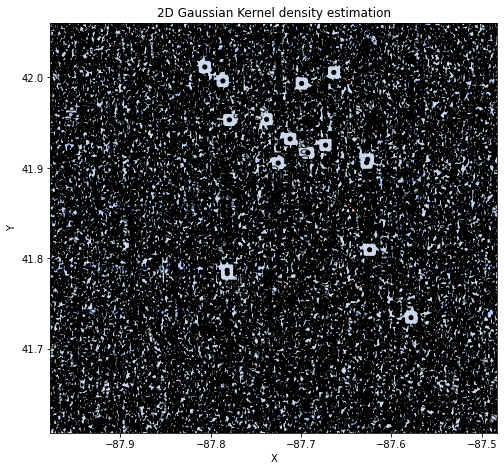

In [29]:
xx, yy = np.mgrid[xmin:xmax:(grid_size*1j), ymin:ymax:(grid_size*1j)]
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
cfset = ax.contourf(xx, yy, data2[-1], cmap='coolwarm')
ax.imshow(np.rot90(data2[-1]), cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, density_matrix_t_series[1], colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('2D Gaussian Kernel density estimation')


In [30]:
print(len(map_arr))
print(data2.shape)

414
(77, 1000, 1000)


In [31]:
frame_from_latest = -6

(41.60687, 42.06083)

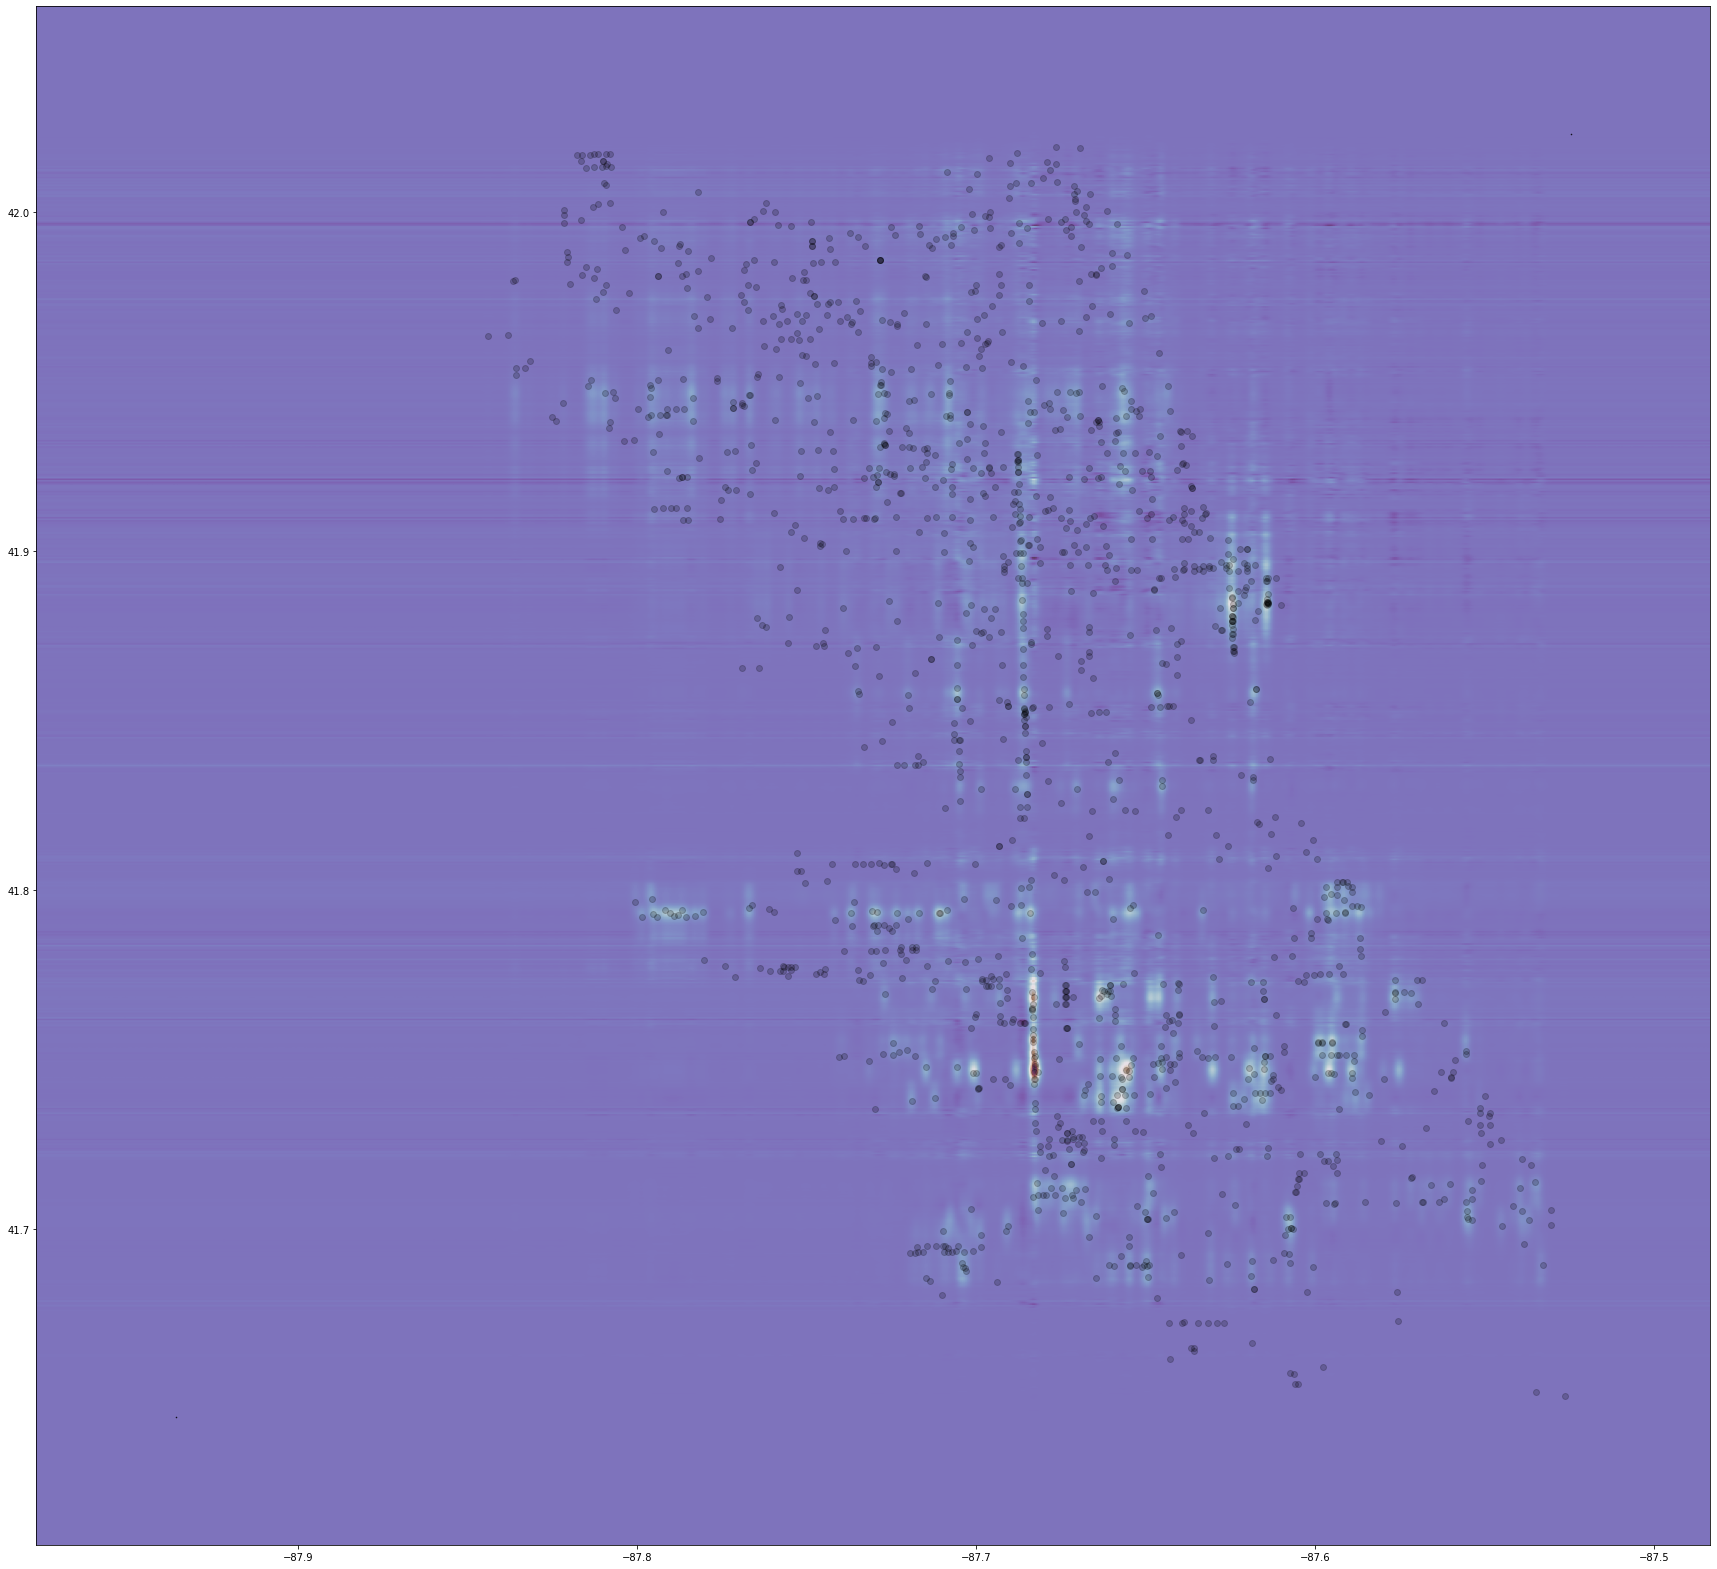

In [32]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [30, 30]
fig1, ax1 = plt.subplots()
ax1.scatter(x="LONGITUDE", y="LATITUDE", data=map_arr[frame_from_latest], c="black", alpha=0.2)
ax1.imshow(np.rot90(data2[frame_from_latest]), cmap=plt.cm.twilight_shifted,alpha=0.8, extent=[xmin, xmax, ymin, ymax])
#ax1.imshow(np.rot90(target_y_test[frame_from_latest]), cmap=plt.cm.hsv,alpha=0.3, extent=[xmin, xmax, ymin, ymax])
ax1.plot(x, y, 'k.', markersize=1)
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])


In [33]:
np.rot90(data2).shape[1]

77

In [34]:
iterable = [np.rot90(matrix) for matrix in data2]

In [35]:
iterable[0].shape

(1000, 1000)

(-87.85041986215067, -87.52523350043245)
(41.65924455069546, 42.019245840973895)


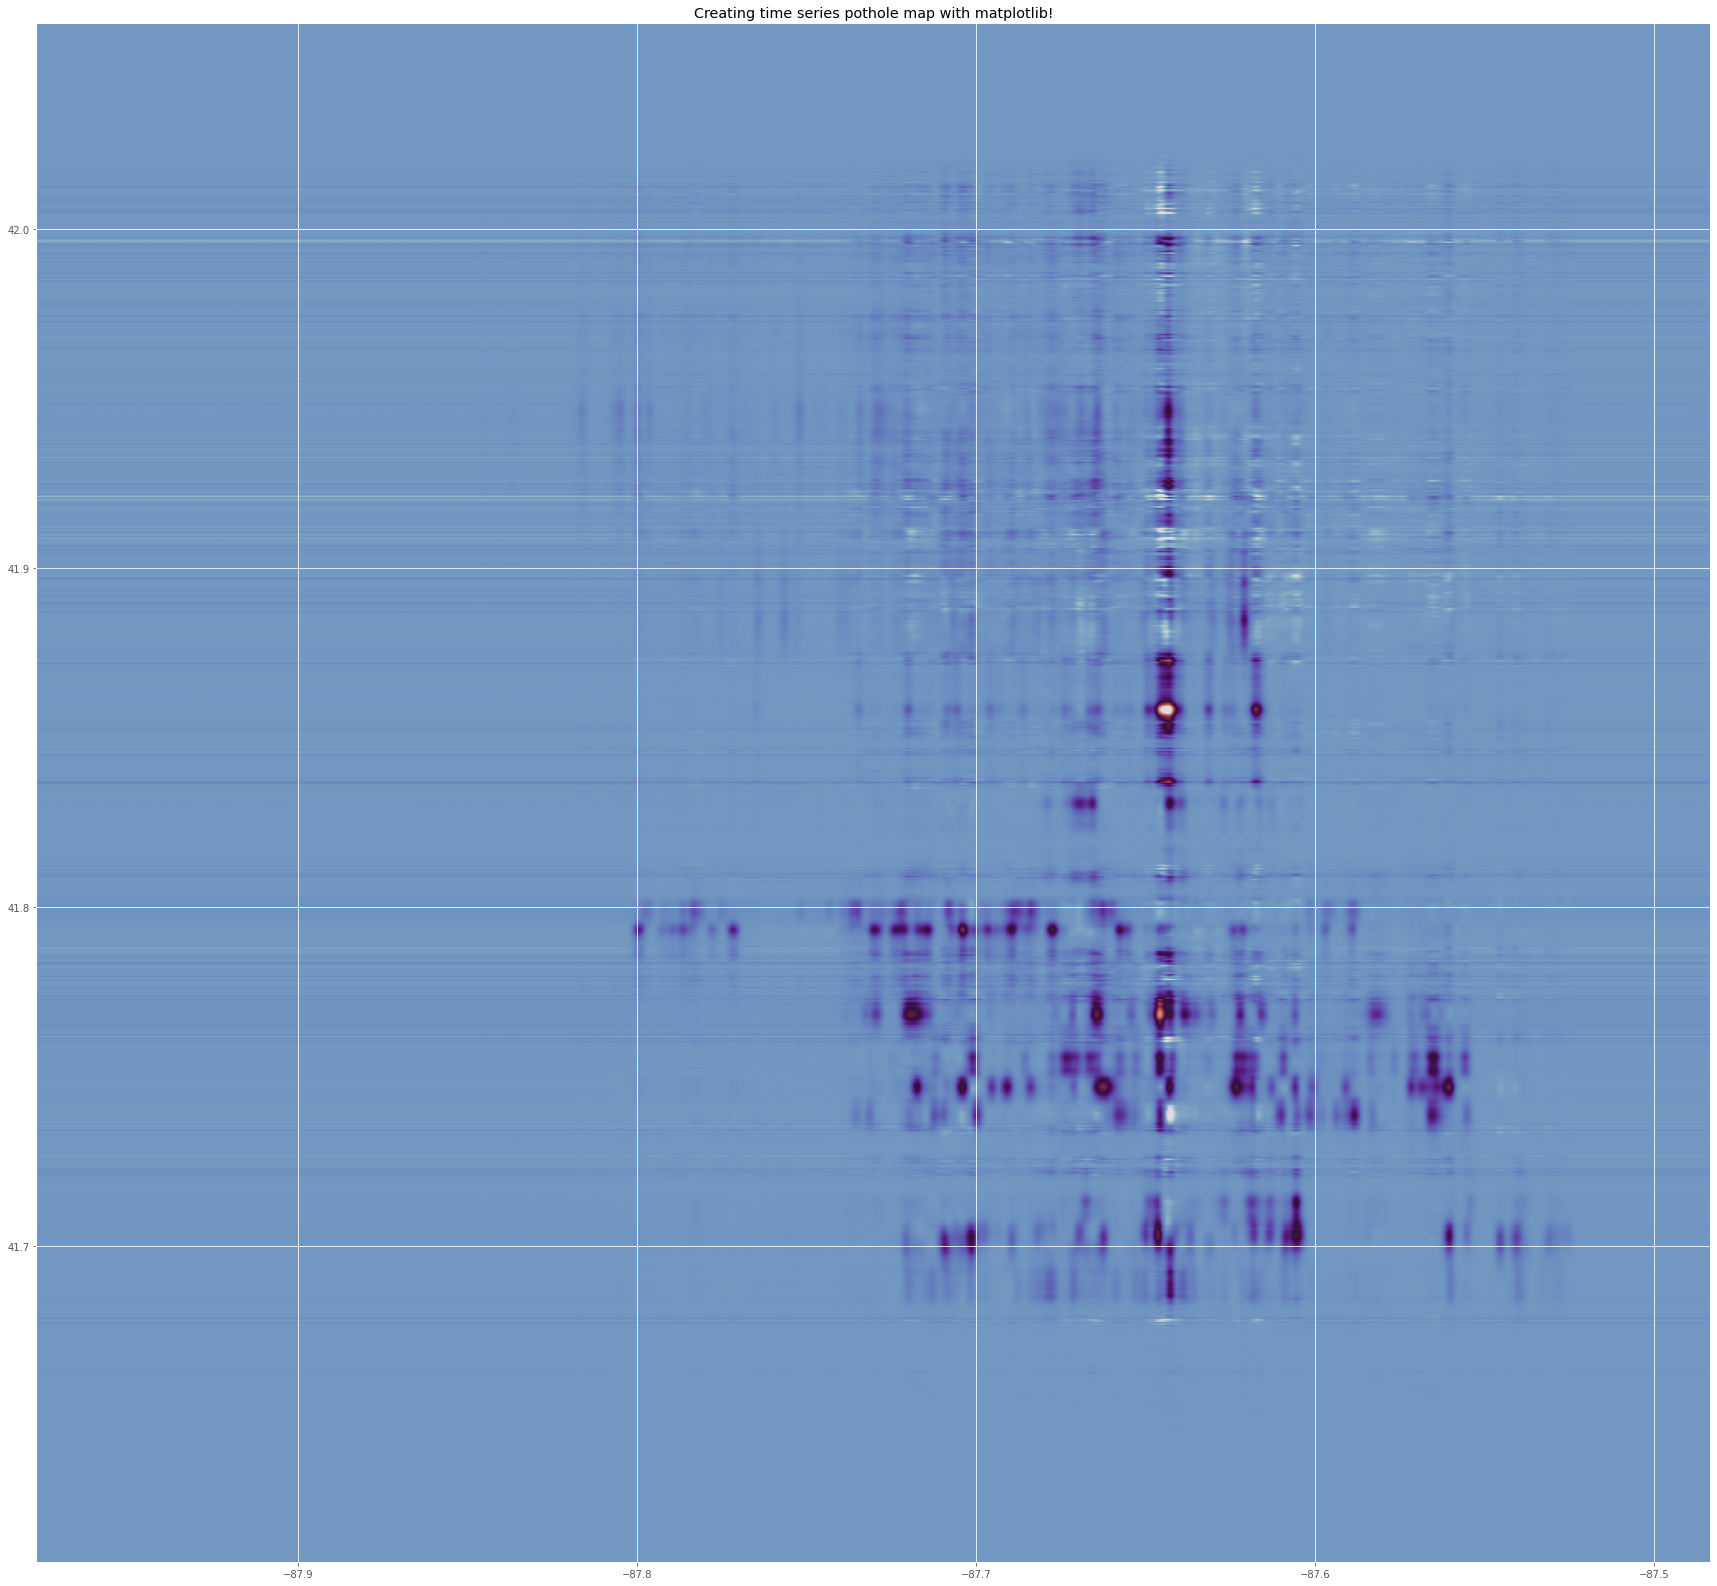

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
plt.style.use('ggplot')
mpl.rcParams['agg.path.chunksize'] = 10000

df = map_arr[-1]
xdata = df["LONGITUDE"].dropna().to_numpy()
ydata = df["LATITUDE"].dropna().to_numpy()
xlim=(min(xdata), max(xdata)) 
ylim=(min(ydata), max(ydata))

print(xlim)
print(ylim)

plt.rcParams["figure.figsize"] = [30, 30]
fig1, ax1 = plt.subplots()
#ax1.scatter(x="LONGITUDE", y="LATITUDE", data=map_arr[frame_from_latest], c="red", alpha=0.4)
im = plt.imshow( X=iterable[0], cmap=plt.cm.twilight, extent=[xmin, xmax, ymin, ymax])


# initialization function 
def init(): 
    # creating an empty plot/frame
    # print("in init")
    im.set_data(iterable[0])
    return [im]


# animation function 
def animate(i):
    #df = map_arr[i]
    #xdata = df["LONGITUDE"].dropna().to_numpy()
    #ydata = df["LATITUDE"].dropna().to_numpy()
    #np.rot90(data2[i])
    #print("in animate")
    im.set_data(iterable[i])
    return [im]

# setting a title for the plot 
plt.title('Creating time series pothole map with matplotlib!') 
# hiding the axis details 
plt.axis('on') 

# call the animator	 
anim = animation.FuncAnimation(fig1, animate, init_func=init,frames=np.arange(0,np.rot90(data2).shape[1],1), interval=100, blit=True,repeat=False) 

# save the animation as mp4 video file 
anim.save(CSV_PATH + 'potholes_zone.gif', writer='imagemagick') 
#plt.show()

In [37]:
int(data.shape[0]/data.shape[1])

77

In [38]:
import pandas as pd
from datetime import timedelta, date
from dateutil.relativedelta import relativedelta

def predictor(model, data_in, grid, start_frame_date, end_frame_date, time_shift):
    xx, yy = grid
    offset = yy.shape[0]
    print("offset = yy.shape[0]" + str(offset))
    xx = xx.ravel()
    yy = yy.ravel()
    xdelta = abs(xx[1] - xx[1+offset])
    ydelta = abs(yy[0] - yy[1+offset])
    print("xdelta"+str(xdelta))
    print("ydelta"+str(ydelta))
    columns = [ 'start_date', 'end_date', 'poly_coordinate', 'density']
    
    pred = model.predict(data_in)
    data = scaler.inverse_transform(scaler2.inverse_transform(pred))
    data_reshaped = data.reshape((int(data.shape[0]/data.shape[1]), data.shape[1], data.shape[1]))
    print(data_reshaped.shape)
    #each cell is a density estimate from KDE that that has been aggregated by number of potholes over time
    #This time interval of density cell is input frame time + timeshift the target frame in the model that has shifted forward by
    
    row_dict = {'start_date' : None, 'end_date' : None, 'poly_coordinate': None, 'density': 0}
    #append = pd.DataFrame(columns=columns)
    dict_list = []
    for t, matrix in enumerate(data_reshaped):
        xy_matrix = np.flip(np.rot90(matrix),0)
        print(xy_matrix.shape)
        row_dict['start_date'] = pd.to_datetime(start_frame_date) + timedelta(days=(time_shift*(t+1)))
        row_dict['end_date'] = pd.to_datetime(end_frame_date) + timedelta(days=(time_shift*(t+1)))
        
        for i, row in enumerate(xy_matrix):
            for j, cell in enumerate(row):
                pos_index = i + j*xy_matrix.shape[1]
                #generate density cell (square) polycoordinate [[cxmin,cymin],[cxmax, cymin],[cxmin, cymax],[cxmax, cymax]]
                row_dict['poly_coordinate'] = [[xx[pos_index],yy[pos_index]],[xx[pos_index]+xdelta,yy[pos_index]],[xx[pos_index]+xdelta,yy[pos_index]+ydelta], [xx[pos_index],yy[pos_index]+ydelta]]
                row_dict['density'] = cell
                dict_list.append(row_dict.copy())

    return pd.DataFrame(dict_list)

In [39]:
x_train2.shape[2]

1000

In [40]:
start_frame_date = '2017-11-01 00:00:00'
end_frame_date = '2018-11-01 00:00:00'
time_shift = 7 #days
dataframe = predictor(model,x_train2[-(x_train2.shape[2]+1):-1], (xx, yy), start_frame_date, end_frame_date, time_shift)

offset = yy.shape[0]1000
xdelta0.0004944144144189977
ydelta0.0004544144144134066
(1, 1000, 1000)
(1000, 1000)


In [41]:
dataframe.shape

(1000000, 4)

In [42]:
dataframe.iloc[0:dataframe.shape[0]].to_csv(CSV_PATH + "2017-11-11_4frames_all")

In [43]:
dataframe['poly_coordinate'].iloc[0]
#dataframe['density'].max()

[[-87.97726, 41.60687],
 [-87.97676558558558, 41.60687],
 [-87.97676558558558, 41.607324414414414],
 [-87.97726, 41.607324414414414]]

In [44]:
from ast import literal_eval

In [45]:
df_test = pd.read_csv("C:\\Users\\Zhimin90\\Documents\\CPT\\Chicago_Pothole_Tracker\\CSV\\2017-11-11_4frames_test.csv",converters={"poly_coordinate": literal_eval})

FileNotFoundError: [Errno 2] File C:\Users\Zhimin90\Documents\CPT\Chicago_Pothole_Tracker\CSV\2017-11-11_4frames_test.csv does not exist: 'C:\\Users\\Zhimin90\\Documents\\CPT\\Chicago_Pothole_Tracker\\CSV\\2017-11-11_4frames_test.csv'

In [48]:
df_test


,Unnamed: 0,start_date,end_date,poly_coordinate,density
0,0,2017-11-11,2018-11-11,"[[-87.97726, 42.06083], [-87.97627018036073, 4...",-2.565649e-16
1,1,2017-11-11,2018-11-11,"[[-87.97726, 42.05992026052105], [-87.97627018...",-2.552543e-16
2,2,2017-11-11,2018-11-11,"[[-87.97726, 42.05901052104209], [-87.97627018...",-2.514947e-16
3,3,2017-11-11,2018-11-11,"[[-87.97726, 42.05810078156313], [-87.97627018...",-2.609710e-16
4,4,2017-11-11,2018-11-11,"[[-87.97726, 42.05719104208417], [-87.97627018...",-2.553703e-16
...,...,...,...,...,...
995,995,2017-11-11,2018-11-11,"[[-87.97627018036073, 41.61050895791583], [-87...",-1.488939e-16
996,996,2017-11-11,2018-11-11,"[[-87.97627018036073, 41.60959921843688], [-87...",-1.559645e-16
997,997,2017-11-11,2018-11-11,"[[-87.97627018036073, 41.60868947895791], [-87...",-1.601375e-16
998,998,2017-11-11,2018-11-11,"[[-87.97627018036073, 41.60777973947896], [-87...",-1.531697e-16


In [50]:
for index, row in df_test.iterrows():
        #print(row['poly_coordinate'])
        start_date = row['start_date']
        end_date = row['end_date']
        #print(row['poly_coordinate'])
        poly_coordinate = ( ((row['poly_coordinate'][0][0], row['poly_coordinate'][0][1]), \
                             (row['poly_coordinate'][1][0], row['poly_coordinate'][1][1]), \
                             (row['poly_coordinate'][2][0], row['poly_coordinate'][2][1]), \
                             (row['poly_coordinate'][3][0], row['poly_coordinate'][3][1])) )
        density = row['density']
        

In [52]:
poly_coordinate[0][1]

41.60687